In [1]:
import json
import os
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pyspark.ml as M
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession

[nltk_data] Downloading package punkt to /home/cahou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/cahou/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
spark = SparkSession \
    .builder \
    .appName("yelp-reccomender") \
    .getOrCreate()

schema = T.StructType([
    T.StructField("_c01", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True),
    T.StructField("business_id", T.StringType(), True),   
    T.StructField("city", T.StringType(), True),   
    T.StructField("categories", T.StringType(), True),
    T.StructField("review_id", T.StringType(), True),   
    T.StructField("text", T.StringType(), True),      
    T.StructField("stars", T.FloatType(), True),
    T.StructField("annotated_rev", T.StringType(), True)
])

lv = spark.read.csv("../data/tmp/Las_Vegas_reviews.csv", header=True, multiLine=True, schema=schema, quote="\"", escape="\"")

In [2]:
# with open('../data/autophrase_in/reviews.txt', 'w') as f:
#     f.write('test')
# with open('../data/autophrase_out/segmentation.txt', 'r') as f:
# with open('../../DSC180A-Project/data/out/segmentation.txt', 'r') as f:
with open('../data/tmp/autophrase_out/DBLP/segmentation.txt', 'r') as f:
# with open('../../DSC180A-Project/data/in/yelp_reviews2.txt', 'r') as f:
    reviews_string = f.read()
    reviews_list = reviews_string.split("\n<<phrase>REVIEW DELIMITER</phrase>>\n")
#     reviews_list = reviews_string.split("\n.\n")

reviews_list = pd.Series(reviews_list)[:-1]

In [5]:
POS=0.3
NEG=-POS

In [3]:
def sentiment_score(reviews_list):
    '''Attach a sentiment score to each sentence of a review. Return DataFrame.'''
    scores = []
    seen_sentences = []
    index = []
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    for i, review in enumerate(reviews_list):
        sentences = tokenizer.tokenize(review)
        sid = SentimentIntensityAnalyzer()
        for sentence in sentences:
            index.append(i)
            seen_sentences.append(sentence)
            ss_intermediate = sid.polarity_scores(sentence)
            scores.append(ss_intermediate)
    df = pd.DataFrame({'index': index, 'sentence': seen_sentences}).join(pd.DataFrame(scores))
    df = df.assign(phrases = df.sentence.apply(lambda x: re.findall('<phrase>.+?</phrase>', x)))
#     df.to_csv('../data/tmp/sentiment.csv', index=False)
#     df = spark.read.csv('../data/tmp/sentiment.csv', schema=schema)
    return df

def clean_phrases(sentences):
    '''Remove the phrase tags'''
    return sentences.str.replace('<phrase>', '').str.replace('</phrase>', '')

def make_positive_phrases(df, val):
    '''Return positive phrases'''
    return clean_phrases(df[['compound', 'phrases']][df['compound']>=val].phrases.explode().dropna()).value_counts()

def make_negative_phrases(df, val):
    '''Return positive phrases'''
    return clean_phrases(df[['compound', 'phrases']][df['compound']<=-val].phrases.explode().dropna()).value_counts()

In [7]:
# sentiment_score_udf(F.udf(lambda x: sentiment_score(x), T.))
# # lv.select(lv.annotated_rev, sentiment_score).alias('hi').show()

In [9]:
lv_pandas = pd.read_csv("../data/tmp/Las_Vegas_reviews.csv")

In [5]:
VAL = 0.3
df_list = []
for i in range(0, len(reviews_list), 1000):
    print(len(reviews_list)-i)
    a = sentiment_score(reviews_list[i:i+1000])
    df_list.append(a)


# a = sentiment_score(reviews_list[0:10000])
# df = sentiment_score(reviews_list)

# positive_phrases = make_positive_phrases(df, VAL)
# negative_phrases = make_negative_phrases(df, VAL)

595540
594540
593540
592540
591540
590540
589540
588540
587540
586540
585540
584540
583540
582540
581540
580540
579540
578540
577540
576540
575540
574540
573540
572540
571540
570540
569540
568540
567540
566540
565540
564540
563540
562540
561540
560540
559540
558540
557540


KeyboardInterrupt: 

In [6]:
df = pd.concat(df_list)

In [9]:
positive_phrases

food                    10024
pizza                    3808
restaurant               3333
friendly                 2156
nice                     1999
                        ...  
extremely consistent        2
standard Chinese            2
hot garlic                  2
changed owners              2
man working                 2
Name: phrases, Length: 9127, dtype: int64

In [7]:
positive_phrases = make_positive_phrases(df, VAL)
negative_phrases = make_negative_phrases(df, VAL)

In [11]:
df.to_csv('../data/tmp/restaurant.csv', index=False)
positive_phrases.to_csv('../data/tmp/positive.csv')
negative_phrases.to_csv('../data/tmp/negative.csv')

In [49]:
d = pd.read_csv('../data/tmp/sentiment.csv')

In [ ]:
schema = T.StructType([
    T.StructField("index", T.IntegerType(), True),
    T.StructField("sentence", T.StringType(), True),
    T.StructField("neg", T.FloatType(), True),   
    T.StructField("neu", T.FloatType(), True),   
    T.StructField("pos", T.FloatType(), True),   
    T.StructField("compound", T.FloatType(), True),   
    T.StructField("phrases", T.ArrayType(), True),      
])

In [112]:
start = lv_pandas[lv_pandas.business_id=='Q_dh08clYUPj13GmCRzIVA'].index.min()

In [113]:
end = lv_pandas[lv_pandas.business_id=='Q_dh08clYUPj13GmCRzIVA'].index.max()

In [115]:
df = df[start:end+1]

In [ ]:
def make_sentimented_restaurant(reviews_list, VAL):
    df = sentiment_score(reviews_list)
    positive_phrases = make_positive_phrases(df, VAL)
    negative_phrases = make_negative_phrases(df, VAL)
    return df, positive_phrases, negative_phrases

In [116]:
clean_phrases(df[df['compound']>=POS].sentence).values

array(['My all time favorite (because of taste and healthiness) is the Teriyaki Chicken Sandwich!',
       'Combined with the Light Minute Maid Lemonade it is an awesome and low calorie meal.',
       'So why would I be giving a Fast Food chain location a 5 star rating?',
       "The chocolate shake IS the best I've EVER had from a drive thru.",
       "The single best chicken strips i've ever had (but they may need new sauces, tired of BBQ...but still outstanding nonetheless).",
       'Brilliant for my late night guru-ness.', 'The manager is sweet.',
       "Yes I do know food I've been in the industry 15 yrs.",
       'Bad place to put them right across from in n out, but when in n out is busy this is a good alternative.',
       "Don't try the new Texas burger, get the Memphis instead(much better deal).",
       'Burger isn\'t bad once you take them off, but then again it\'s pretty much a Memphis with less "brisket."',
       'Can enjoy the $6 dollar burger either with bun or low c

In [117]:
clean_phrases(df[['compound', 'phrases']][df['compound']>=POS].phrases.explode().dropna()).value_counts()

chicken             8
food                8
sauces              6
Honey               4
friendly            4
                   ..
sandwich            1
corn                1
pepper              1
games               1
customer service    1
Name: phrases, Length: 91, dtype: int64

In [118]:
clean_phrases(df[df['compound']<=NEG].sentence).values

array(['The cook that works on late shift SUCKS.',
       'never have i ate anywhere to the level of grossness this place offered.',
       'So after being in shock of what just happened i took the bun off once again and saw some of my lettuce was black.',
       'And the worst part it that the chicken patty was grey with some spots of meat missing inside its really hard to explain when i called the manager she really was not too concerned with the quality offered me to remake the burger .',
       'So when i got there i went inside for my refund and it was not the best looking inside either all the employees seemed to not even care that they served me that and they gave me a small fountain cup while i waited and the soda was flat.',
       'I then realized the problem is with management and not running that location right.',
       'Lack of employee quality.', 'The jalapeño straws are worthless!',
       'The bad part is they are over priced for em though.',
       'Their restraints h

In [119]:
clean_phrases(df[['compound', 'phrases']][df['compound']<=NEG].phrases.explode().dropna()).value_counts()

onion            4
fries            4
lacked flavor    2
manager          2
months ago       2
sauce            2
Meat             2
order            2
hot sauce        2
late shift       1
bun              1
chicken patty    1
black            1
restaurant       1
fountain         1
meat             1
food             1
management       1
jalapeño         1
remake           1
lettuce          1
Name: phrases, dtype: int64

In [83]:
df, positive_phrases, negative_phraes = make_sentimented_restaurant(reviews_list[0:59], VAL)

NameError: name 'make_sentimented_restaurant' is not defined

In [84]:
positive_phrases[0:5]#[0:10]

food          3683
vegan         1615
restaurant    1400
meat           878
friendly       821
Name: phrases, dtype: int64

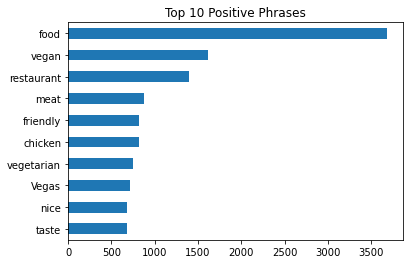

In [85]:
positive_phrases[0:10].plot.barh(title='Top 10 Positive Phrases').invert_yaxis()

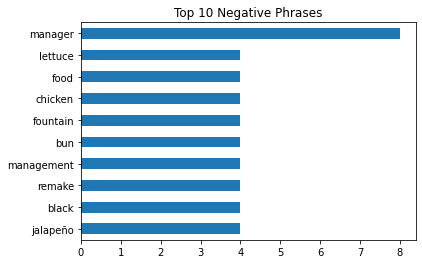

In [28]:
negative_phrases[0:10].plot.barh(title='Top 10 Negative Phrases').invert_yaxis()

In [15]:
df = df.assign(tokens=df.sentence.str.split(' '))

In [48]:
df = df.assign(tokens=df.tokens.apply(lambda x: len(x)))

In [16]:
df.tokens

,index,sentence,neg,neu,pos,compound,phrases,tokens
0,0,So why would I be giving a <phrase>Fast Food c...,0.000,0.806,0.194,0.3400,"[<phrase>Fast Food chain</phrase>, <phrase>sta...","[So, why, would, I, be, giving, a, <phrase>Fas..."
1,0,"For some reason, THIS <phrase>Carl's Jr</phrase>.",0.000,1.000,0.000,0.0000,[<phrase>Carl's Jr</phrase>],"[For, some, reason,, THIS, <phrase>Carl's, Jr<..."
2,0,is one in a million.,0.000,1.000,0.000,0.0000,[],"[is, one, in, a, million.]"
3,0,"Yes, there is an In-and-Out across the street ...",0.000,0.896,0.104,0.2144,[<phrase>Carl's Jr</phrase>],"[Yes,, there, is, an, In-and-Out, across, the,..."
4,0,"First of all, THEIR SHAKES!!!",0.000,1.000,0.000,0.0000,[],"[First, of, all,, THEIR, SHAKES!!!]"
...,...,...,...,...,...,...,...,...
6295,999,"The <phrase>egg</phrase> rolls were great, and...",0.000,0.552,0.448,0.8070,"[<phrase>egg</phrase>, <phrase>crab</phrase>, ...","[The, <phrase>egg</phrase>, rolls, were, great..."
6296,999,Despite being close to <phrase>china</phrase> ...,0.111,0.889,0.000,-0.2488,"[<phrase>china</phrase>, <phrase>town</phrase>]","[Despite, being, close, to, <phrase>china</phr..."
6297,999,<phrase>Online ordering</phrase> and delivery ...,0.000,1.000,0.000,0.0000,[<phrase>Online ordering</phrase>],"[<phrase>Online, ordering</phrase>, and, deliv..."
6298,999,<phrase>Wor</phrase> <phrase>wonton</phrase> i...,0.246,0.590,0.164,-0.1675,"[<phrase>Wor</phrase>, <phrase>wonton</phrase>...","[<phrase>Wor</phrase>, <phrase>wonton</phrase>..."


In [63]:
df_rev = df.groupby('index')[['compound', 'tokens']].sum()

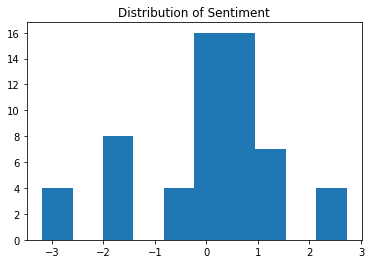

In [72]:
plt.hist(df_rev.compound)
plt.title(label='Distribution of Sentiment')
plt.show()

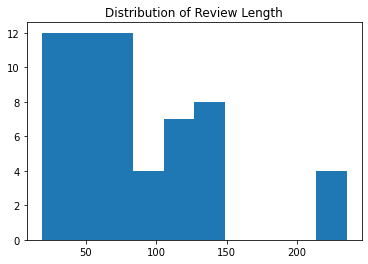

In [73]:
plt.hist(df_rev.tokens)
plt.title(label='Distribution of Review Length')
plt.show()

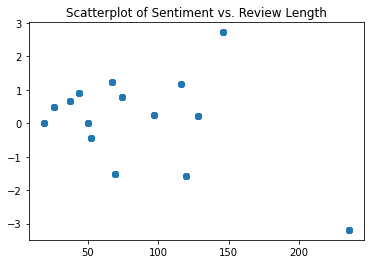

In [69]:
plt.scatter(x=df_rev['tokens'], y=df_rev['compound'])
plt.title("Scatterplot of Sentiment vs. Review Length")
plt.show()

In [77]:
positive_phrases

chicken             16
Memphis              8
guru                 4
Fast Food chain      4
industry             4
bit                  4
waffle               4
drive thru           4
classics             4
turkey               4
brisket              4
manager              4
town                 4
Carl's Jr            4
star                 4
guacamole            4
strips               4
sauces               4
low carb             4
fast food            4
late night           4
food                 4
customer service     4
dollar burger        4
fried zucchini       4
bun                  4
hand breaded         4
single               4
chocolate            4
alternative          4
Texas                4
fries                4
sandwich             4
Teriyaki             3
Chicken              3
Minute Maid          3
low calorie          3
Lemonade             3
taste                3
Light                3
Sandwich             3
Name: phrases, dtype: int64

In [5]:
lv

,Unnamed: 0,name,business_id,city,categories,review_id,text,stars
0,0,Carl's Jr,fnZrZlqW1Z8iWgTVDfv_MA,Las Vegas,"Mexican, Restaurants, Fast Food",WUAt5-krh075Ie44np8Hew,So why would I be giving a Fast Food chain loc...,5.0
1,1,Carl's Jr,fnZrZlqW1Z8iWgTVDfv_MA,Las Vegas,"Mexican, Restaurants, Fast Food",S9vIs-je49jqbhpWSQ8yHg,I come here bout 3x's a mo. & I just can't do ...,2.0
2,2,Carl's Jr,fnZrZlqW1Z8iWgTVDfv_MA,Las Vegas,"Mexican, Restaurants, Fast Food",i2Soid_X8XsSTyIrPOst6g,WORST experience EVER!!!!! never have i ate an...,1.0
3,3,Carl's Jr,fnZrZlqW1Z8iWgTVDfv_MA,Las Vegas,"Mexican, Restaurants, Fast Food",uDYGaAOUgo7SLuH5nUZs3w,Hot fresh food usually. Staff seems to turn o...,4.0
4,4,Carl's Jr,fnZrZlqW1Z8iWgTVDfv_MA,Las Vegas,"Mexican, Restaurants, Fast Food",Xg7HuBvuZHTBog1G_2Wk0w,Beer battered cod fish seems really rubbery. I...,3.0
...,...,...,...,...,...,...,...,...
595535,595535,S+O Restaurant,lsLelczQjIZLHVt2-e44lA,Las Vegas,"American (Traditional), Restaurants, American ...",1BPh4QS80bUS47agxN9UMA,"The service was slow every time we went here, ...",4.0
595536,595536,S+O Restaurant,lsLelczQjIZLHVt2-e44lA,Las Vegas,"American (Traditional), Restaurants, American ...",8eTVWv0lBAaYYuUdrWO65Q,Food wasn't that bAd but the service was not s...,3.0
595537,595537,S+O Restaurant,lsLelczQjIZLHVt2-e44lA,Las Vegas,"American (Traditional), Restaurants, American ...",abFueTdsvK4xAkmF_53U9w,I absolutely love the décor and color scheme i...,3.0
595538,595538,S+O Restaurant,lsLelczQjIZLHVt2-e44lA,Las Vegas,"American (Traditional), Restaurants, American ...",X2STQTenLN4w6LPV0TqIpA,What a cute place! We decided to eat here beca...,4.0


In [6]:
reviews_list

0         So why would I be giving a <phrase>Fast Food c...
1         I come here bout 3x's a mo. & I just can't do ...
2         <phrase>WORST experience</phrase> EVER!!!!! ne...
3         <phrase>Hot fresh</phrase> <phrase>food</phras...
4         <phrase>Beer battered cod</phrase> <phrase>fis...
                                ...                        
595535    The service was slow every time we went here, ...
595536    <phrase>Food</phrase> wasn't that bAd but the ...
595537    I <phrase>absolutely love</phrase> the décor a...
595538    What a <phrase>cute place</phrase>! We decided...
595539    I'm so sick of this place! There won't be one ...
Length: 595540, dtype: object